*Note: Please refer to "vit_from_head.ipynb" for introdution to self-attention mechanism, as it is simpler for vit than gemma models.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import GemmaModel, GemmaConfig, AutoTokenizer, AutoModelForCausalLM

c:\Users\lazar\miniconda3\envs\modern_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b")

Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.43s/it]


In [ ]:
# input_text = """Write me a poem about Machine Learning.

# I’m not sure what you mean"""
# input_ids = tokenizer(input_text, return_tensors="pt")

# outputs = model.generate(**input_ids)
# print(tokenizer.decode(outputs[0]))

In [49]:
weights = model.state_dict()
config = model.config
config

GemmaConfig {
  "_name_or_path": "google/gemma-2b",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.41.0",
  "use_cache": true,
  "vocab_size": 256000
}

In [50]:
# Tokenization parameters
vocab_size = config.vocab_size
bos_token_id = config.bos_token_id
eos_token_id = config.eos_token_id
pad_token_id = config.pad_token_id

# Embedding parameters
dim = config.hidden_size
max_position_embeddings = config.max_position_embeddings
rope_theta = config.rope_theta

# RMSNorm parameters
rms_norm_eps = config.rms_norm_eps

# General transformer parameters
n_layers = config.num_hidden_layers
fc_intermediate_size = config.intermediate_size

# Attention parameters
n_heads = config.num_attention_heads
num_key_value_heads = config.num_key_value_heads
head_dim = dim // n_heads

# Deriving all modules (can be skipped)

## Tokenize the sentence

In [7]:
sentence = "You are my moon!"
tokens = tokenizer(sentence, return_tensors='pt')
tokens

{'input_ids': tensor([[     2,   2045,    708,    970,  11883, 235341]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

## Embedding the tokens

In [8]:
embedding_layer = nn.Embedding(vocab_size, dim)
print(embedding_layer.weight.shape, weights['model.embed_tokens.weight'].shape)

torch.Size([256000, 2048]) torch.Size([256000, 2048])


In [9]:
embedding_layer.weight.data = weights['model.embed_tokens.weight']

In [10]:
embedding = embedding_layer(tokens.input_ids)

In [11]:
# Let's now compare our layer output to the original
torch.all(embedding == model.model.embed_tokens(tokens.input_ids))

tensor(True)

## Rotary positionaly encoding

In [12]:
# Let's see what we have in the original ROPE
orig_rotary_emb = model.model.layers[0].self_attn.rotary_emb
orig_rotary_emb.dim, orig_rotary_emb.max_position_embeddings, orig_rotary_emb.base

(256, 8192, 10000.0)

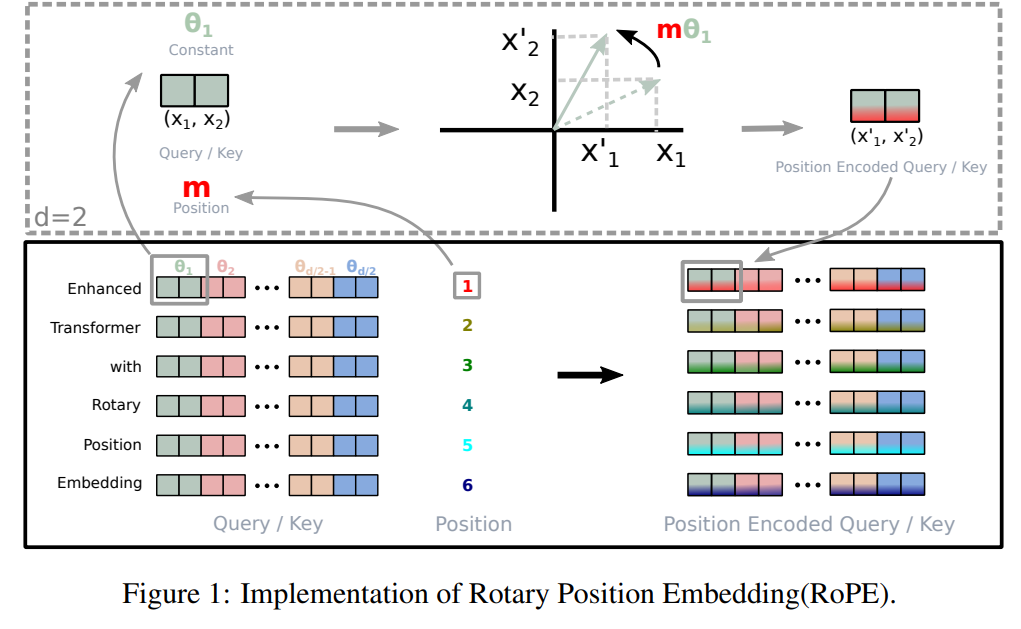
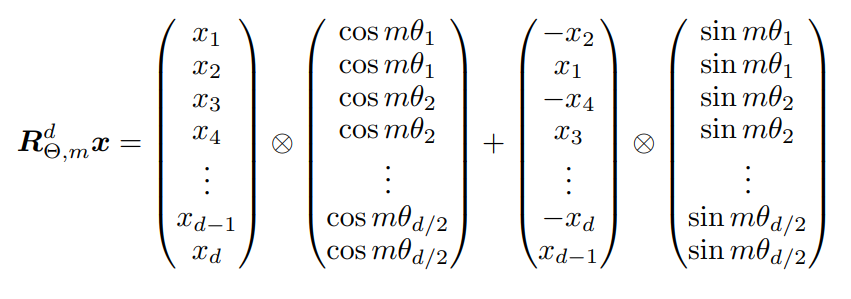
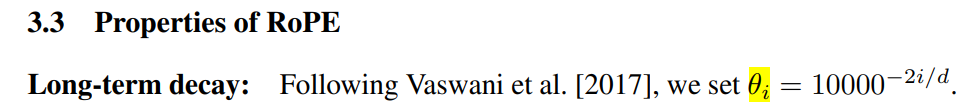

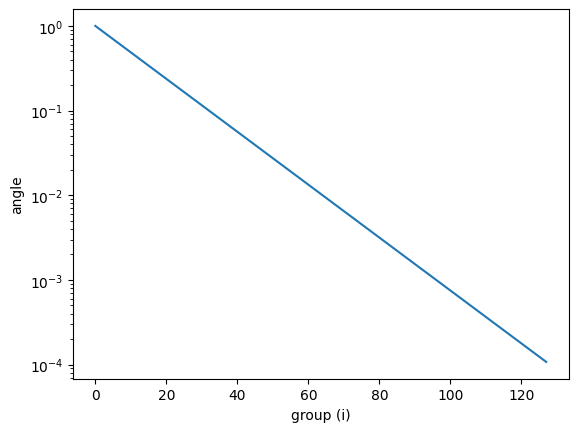

In [13]:
angles = torch.Tensor([10000**(-2*i/head_dim) for i in range(head_dim//2)])
plt.plot(angles)
plt.ylabel('angle')
plt.xlabel('group (i)')
plt.yscale('log')

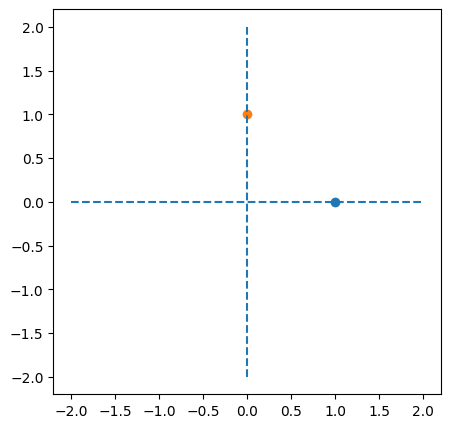

In [14]:
# Let's test rotation on single 2D vector
# our embeddings are composed of dim//2 2D vectors that will be rotated in similar manner
angle = torch.Tensor([torch.pi/2])
vec = torch.Tensor([1,0])
rot_transform = torch.Tensor([
    [torch.cos(angle), -torch.sin(angle)],
    [torch.sin(angle), torch.cos(angle)]
])
# print(rot_transform)

# rot_vec = rot_transform @ vec
rot_vec = [
    (vec*rot_transform[0]).sum(),
    (vec*rot_transform[1]).sum()
]

# print(vec, rot_vec)

plt.figure(figsize=(5,5))
plt.hlines([0], -2, 2, linestyles='--')
plt.vlines([0], -2, 2, linestyles='--')
plt.scatter([vec[0]], [vec[1]])
plt.scatter([rot_vec[0]], [rot_vec[1]])

Let's now perform the same thing on whole embedding vector

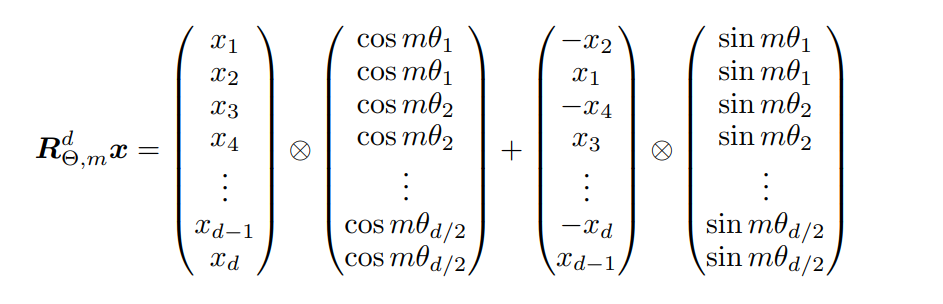

In [15]:
torch.cos(torch.Tensor([0.000001*6, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]))

tensor([ 1.0000e+00, -4.3711e-08, -1.0000e+00,  1.1925e-08,  1.0000e+00])

In [16]:
seq_len = embedding.shape[-2]#//100


# first we create sin and cos vectors
cos_vec = torch.Tensor([[torch.cos(angle*m), torch.cos(angle*m)] for m in range(1,seq_len+1) for angle in angles[:head_dim//2]]).reshape(seq_len, -1)
print("cos_vec", cos_vec, cos_vec.shape)
sin_vec = torch.Tensor([[torch.sin(angle*m), torch.sin(angle*m)] for m in range(1,seq_len+1) for angle in angles[:head_dim//2]]).reshape(seq_len, -1)
print("sin_vec", sin_vec, sin_vec.shape)

cos_vec tensor([[ 0.5403,  0.5403,  0.5974,  ...,  1.0000,  1.0000,  1.0000],
        [-0.4161, -0.4161, -0.2863,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9900, -0.9900, -0.9394,  ...,  1.0000,  1.0000,  1.0000],
        [-0.6536, -0.6536, -0.8361,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.2837,  0.2837, -0.0595,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9602,  0.9602,  0.7650,  ...,  1.0000,  1.0000,  1.0000]]) torch.Size([6, 256])
sin_vec tensor([[ 8.4147e-01,  8.4147e-01,  8.0196e-01,  ...,  1.1548e-04,
          1.0746e-04,  1.0746e-04],
        [ 9.0930e-01,  9.0930e-01,  9.5814e-01,  ...,  2.3096e-04,
          2.1492e-04,  2.1492e-04],
        [ 1.4112e-01,  1.4112e-01,  3.4278e-01,  ...,  3.4643e-04,
          3.2238e-04,  3.2238e-04],
        [-7.5680e-01, -7.5680e-01, -5.4861e-01,  ...,  4.6191e-04,
          4.2984e-04,  4.2984e-04],
        [-9.5892e-01, -9.5892e-01, -9.9823e-01,  ...,  5.7739e-04,
          5.3730e-04,  5.3730e-04],
        [-2.7942e-01, -2.79

In [762]:
# cos_vec = torch.Tensor([torch.cos(angle*m) for m in range(1,seq_len+1) for angle in angles[:head_dim//2]]).reshape(seq_len, -1)
# cos_vec = torch.cat((cos_vec,cos_vec),1)
# sin_vec = torch.Tensor([torch.sin(angle*m) for m in range(1,seq_len+1) for angle in angles[:head_dim//2]]).reshape(seq_len, -1)
# sin_vec = torch.cat((sin_vec,sin_vec),1)
# print("cos_vec", cos_vec, cos_vec.shape)


In [365]:
# Let's rearange example feature columns
# later we can do the same for emmbeding to get [-x2, x1, -x4, x3, .... -xd, xd-1]

# Example matrix creation
matrix = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12]])

# Rearranging the columns
new_order = [i + 1 if i % 2 == 0 else i - 1 for i in range(matrix.shape[1])]
rearranged_matrix = matrix[:, new_order]
rearranged_matrix[:, 0::2] = -rearranged_matrix[:, 0::2]

print(matrix)

print(rearranged_matrix)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[[ -2   1  -4   3]
 [ -6   5  -8   7]
 [-10   9 -12  11]]


In [448]:
new_order = [i + 1 if i % 2 == 0 else i - 1 for i in range(embedding.shape[-1])]
rearranged_embedding = embedding[:, :, new_order]
rearranged_embedding[:, :, 0::2] = -rearranged_embedding[:, :, 0::2]

In [449]:
rotated_embedding = ((embedding[:,:,:head_dim] * cos_vec) + (rearranged_embedding[:,:,:head_dim] * sin_vec))

In [370]:
embedding[0,0,0]

tensor(0.1191, grad_fn=<SelectBackward0>)

Text(0.5, 1.0, 'vector rotation for angle 101.16 degrees')

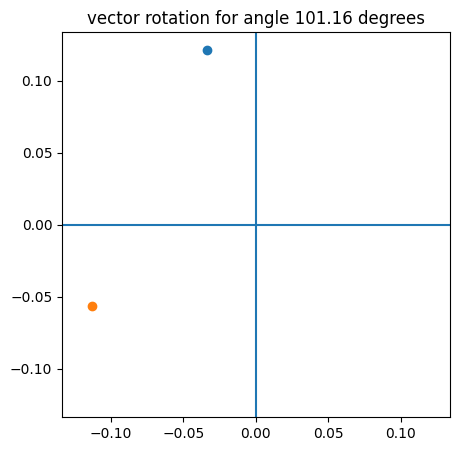

In [372]:
# let's check if the rotation has worked on first pair of features
# picking different pair_id will select a different pairs of embedding and angles
# picking different token_ind will lead to (token_ind+1)*angle rotation
pair_ind = 17 # angle at index 107 is ~45 deg
token_ind = 5
angle_in_deg = 180/torch.pi * angles[pair_ind] * (token_ind+1)

plt.figure(figsize=(5,5))
vec = embedding[0,token_ind,pair_ind*2:(pair_ind+1)*2].detach().numpy()
rot_vec = rotated_embedding[0,token_ind,pair_ind*2:(pair_ind+1)*2].detach().numpy()

scale_lim = max(np.max(np.abs(vec)), np.max(np.abs(rot_vec))) * 1.1
plt.axhline(0)
plt.axvline(0)
plt.scatter([vec[0]], [vec[1]])
plt.scatter([rot_vec[0]], [rot_vec[1]])
plt.xlim([-scale_lim,scale_lim])
plt.ylim([-scale_lim,scale_lim])
plt.title(f"vector rotation for angle {angle_in_deg:.2f} degrees")

In [373]:
print(rotated_embedding)

tensor([[[ 0.0482,  0.1106, -0.0207,  ..., -0.0913, -0.0023,  0.0134],
         [-0.0438,  0.2066,  0.0482,  ..., -0.0942,  0.0664, -0.0654],
         [-0.2125,  0.0457,  0.0383,  ..., -0.1357,  0.0579, -0.0869],
         [-0.1811, -0.1869,  0.0805,  ..., -0.1177,  0.0645, -0.0439],
         [-0.0037, -0.2801,  0.0678,  ..., -0.2002, -0.0269,  0.0093],
         [ 0.2137, -0.0169, -0.0746,  ..., -0.0776,  0.0640,  0.0107]]],
       grad_fn=<AddBackward0>)


In [374]:
torch.arange(1, seq_len+1).unsqueeze(0)

tensor([[1, 2, 3, 4, 5, 6]])

In [733]:
position_ids = torch.Tensor([1,2,3,4,5,6]).unsqueeze(0)
print(position_ids.shape)

bsz, seq_len, _ = embedding.shape

cos_gt, sin_gt = model.model.layers[0].self_attn.rotary_emb(torch.rand((bsz,n_heads,seq_len,head_dim)), position_ids=position_ids)

print(cos_gt.sum(),cos_vec.sum())

print(cos_gt.shape, sin_gt.shape)

print(cos_gt.squeeze())
print(cos_vec, cos_vec.shape)



torch.Size([1, 6])
tensor(1264.0383) tensor(1264.0385)
torch.Size([1, 6, 256]) torch.Size([1, 6, 256])
tensor([[ 0.5403,  0.5974,  0.6479,  ...,  1.0000,  1.0000,  1.0000],
        [-0.4161, -0.2863, -0.1604,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9900, -0.9394, -0.8558,  ...,  1.0000,  1.0000,  1.0000],
        [-0.6536, -0.8361, -0.9485,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.2837, -0.0595, -0.3733,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9602,  0.7650,  0.4648,  ...,  1.0000,  1.0000,  1.0000]])
tensor([[ 0.5403,  0.5403,  0.5974,  ...,  1.0000,  1.0000,  1.0000],
        [-0.4161, -0.4161, -0.2863,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9900, -0.9900, -0.9394,  ...,  1.0000,  1.0000,  1.0000],
        [-0.6536, -0.6536, -0.8361,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.2837,  0.2837, -0.0595,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9602,  0.9602,  0.7650,  ...,  1.0000,  1.0000,  1.0000]]) torch.Size([6, 256])


In [745]:
cos_gt[0,:,:128] == cos_gt[0,:,128:]

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, 

In [756]:
# Let's now compare our sin and cos matrices from ROPE to the original
torch.allclose(cos_gt.squeeze(), cos_vec, atol=1e-5), torch.allclose(sin_gt.squeeze(), sin_vec, atol=1e-5)

(True, True)

In [17]:
# HF transformers gemma code used in GemmaAttention module 

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [643]:
embedding.reshape([bsz, seq_len,n_heads,head_dim]).transpose(1, 2).shape#.reshape(bsz, n_heads, seq_len*2, head_dim//2).transpose(2, 3).transpose(1, 2)

torch.Size([1, 8, 6, 256])

In [748]:
bsz, seq_len = embedding.shape[0], embedding.shape[1]

reshaped_emb = embedding.view([bsz, seq_len,n_heads,head_dim]).transpose(1, 2)#.transpose(2, 3).reshape([bsz, n_heads, head_dim//2, -1]).transpose(1, 2)
print(reshaped_emb.shape)

gt_full_rotated_emb , _ = apply_rotary_pos_emb(reshaped_emb, reshaped_emb, cos_gt, sin_gt)#, unsqueeze_dim=1)
print(gt_full_rotated_emb.shape)
# gt_full_rotated_emb = gt_full_rotated_emb.transpose(2,3).transpose(-2, -1).reshape([bsz,n_heads,seq_len,head_dim])
# print(gt_full_rotated_emb.shape)

torch.Size([1, 8, 6, 256])
torch.Size([1, 8, 6, 256])


In [717]:
# gt_full_rotated_emb = gt_full_rotated_emb.transpose(2,3).reshape([bsz,n_heads,head_dim,seq_len]).transpose(-2, -1)
gt_full_rotated_emb.shape

torch.Size([1, 8, 6, 256])

In [853]:
# full_rotated_embedding = rearranged_embedding.view([bsz,seq_len,n_heads,head_dim]).transpose(1, 2) * sin_vec \
#                                   + embedding.view([bsz,seq_len,n_heads,head_dim]).transpose(1, 2) * cos_vec

index = torch.arange(0,head_dim).reshape(2,-1).transpose(0,1).reshape(-1)
revert_index = torch.arange(0,head_dim).reshape(-1,2).T.flatten()
# print(index, revert_index)
ee = embedding.view([bsz,seq_len,n_heads,head_dim]).transpose(1, 2)#[:,:,:,index]
ee = ee[:,:,:,index]

new_order = [i + 1 if i % 2 == 0 else i - 1 for i in range(ee.shape[-1])]
re = ee[:, :, :, new_order]
re[:, :, :, 0::2] = -re[:, :, :, 0::2]
full_rotated_embedding = re * sin_vec + ee * cos_vec
full_rotated_embedding = full_rotated_embedding[:,:,:,revert_index]

In [915]:
x = torch.zeros((128, 12, 2048*2, 256))
new_order = [i + 1 if i % 2 == 0 else i - 1 for i in range(x.shape[-1])]

In [913]:
for i in range(10):
    rx = x[:, :, :, new_order]
    rx[:, :, :, 0::2] = -rx[:, :, :, 0::2]
del rx

In [916]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)
for i in range(10):
    rotate_half(x)
del x

In [917]:
gt_full_rotated_emb.sum(), full_rotated_embedding.sum()

(tensor(-11.1253, grad_fn=<SumBackward0>),
 tensor(-11.1253, grad_fn=<SumBackward0>))

In [852]:
# Let's now compare ours vs gt rotated embedding 
torch.allclose(gt_full_rotated_emb, full_rotated_embedding, atol=1e-7)

True

## RMSNorm

In [18]:
pretrained_layer_0_input_rmsnorm_gains = weights['model.layers.0.input_layernorm.weight']
print(pretrained_layer_0_input_rmsnorm_gains.shape)

torch.Size([2048])


In [19]:
rmse_gains = torch.rand((dim))
rmse_gains = pretrained_layer_0_input_rmsnorm_gains
rmse_gains.shape

torch.Size([2048])

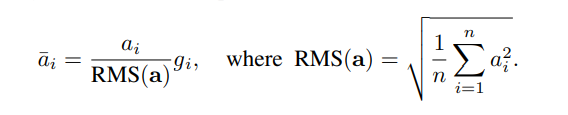

In [20]:
# Compute the RMS
x = embedding
rms = torch.sqrt(
    torch.mean(x**2, -1, keepdim=True) + rms_norm_eps
) 
print(rms.shape)


torch.Size([1, 6, 1])


In [21]:

x_fp32 = x.float()
x_normed = (
    x_fp32 * torch.rsqrt(x_fp32.pow(2).mean(-1, keepdim=True) + rms_norm_eps)
).type_as(x)
x_normed * (1+rmse_gains)

tensor([[[ 0.0000,  0.1972, -0.1383,  ..., -0.0531,  0.0031, -0.0789],
         [ 0.0000, -1.4100, -1.2319,  ..., -0.5512,  1.2973, -0.5809],
         [ 0.0000, -0.5370, -0.9132,  ..., -0.3765,  1.2014,  0.2920],
         [ 0.0000, -0.4899, -0.8501,  ..., -0.3425,  2.6248, -0.7359],
         [ 0.0000, -2.2187, -0.8510,  ..., -0.0891,  1.3116, -0.5390],
         [ 0.0000,  1.6368, -2.4607,  ...,  0.2069,  0.5042, -1.2183]]],
       grad_fn=<MulBackward0>)

In [22]:
# Scale the input with RMS and gains
# Be careful, gemma paper adds 1 to the gains, opposed to what I expected based on the RMSNorm paper
x = x / rms * (1 + rmse_gains)
print(x.shape)
x

torch.Size([1, 6, 2048])


tensor([[[ 0.0000,  0.1972, -0.1383,  ..., -0.0531,  0.0031, -0.0789],
         [ 0.0000, -1.4100, -1.2319,  ..., -0.5512,  1.2973, -0.5809],
         [ 0.0000, -0.5370, -0.9132,  ..., -0.3765,  1.2014,  0.2920],
         [ 0.0000, -0.4899, -0.8501,  ..., -0.3425,  2.6248, -0.7359],
         [ 0.0000, -2.2187, -0.8510,  ..., -0.0891,  1.3116, -0.5390],
         [ 0.0000,  1.6368, -2.4607,  ...,  0.2069,  0.5042, -1.2183]]],
       grad_fn=<MulBackward0>)

In [23]:
# Compare out output with original gemmas RMSNorm layer
orig_rms_output = model.model.layers[0].input_layernorm(embedding)
orig_rms_output

tensor([[[ 0.0000,  0.1972, -0.1383,  ..., -0.0531,  0.0031, -0.0789],
         [ 0.0000, -1.4100, -1.2319,  ..., -0.5512,  1.2973, -0.5809],
         [ 0.0000, -0.5370, -0.9132,  ..., -0.3765,  1.2014,  0.2920],
         [ 0.0000, -0.4899, -0.8501,  ..., -0.3425,  2.6248, -0.7359],
         [ 0.0000, -2.2187, -0.8510,  ..., -0.0891,  1.3116, -0.5390],
         [ 0.0000,  1.6368, -2.4607,  ...,  0.2069,  0.5042, -1.2183]]],
       grad_fn=<MulBackward0>)

In [24]:
# Let's now compare our layer output to the original
torch.all(x == orig_rms_output)

tensor(False)

In [25]:
# Damn, it's not the same, but let's see if it's almost the same
torch.allclose(x, orig_rms_output)
# Nice :D

True

In [256]:
# Let's create a RMSN module
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.gains = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        rms = torch.sqrt(
            torch.mean(x**2, -1, keepdim=True) + self.eps
        )
        x = x / rms * (1 + self.gains)
        return x

rmsn_layer = RMSNorm(dim, eps=rms_norm_eps)
rmsn_layer.gains.data = pretrained_layer_0_input_rmsnorm_gains
torch.allclose(rmsn_layer(embedding), orig_rms_output)

True

## Multi-query attention

In [1237]:
head_dim * n_heads

2048

In [1238]:
list(weights.keys())[:10]

['model.embed_tokens.weight',
 'model.layers.0.self_attn.q_proj.weight',
 'model.layers.0.self_attn.k_proj.weight',
 'model.layers.0.self_attn.v_proj.weight',
 'model.layers.0.self_attn.o_proj.weight',
 'model.layers.0.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.0.mlp.down_proj.weight',
 'model.layers.0.input_layernorm.weight',
 'model.layers.0.post_attention_layernorm.weight']

In [1239]:
# create q, k, v weights for all heads
q_proj = nn.Linear(dim, head_dim * n_heads, bias=False) # dim x dim
k_proj = nn.Linear(dim, head_dim * num_key_value_heads, bias=False)
v_proj = nn.Linear(dim, head_dim * num_key_value_heads, bias=False)
o_proj = nn.Linear(dim, head_dim * n_heads, bias=False)

print(q_proj.weight.shape, k_proj.weight.shape, v_proj.weight.shape, o_proj.weight.shape)
print(
    weights["model.layers.0.self_attn.q_proj.weight"].shape,
    weights["model.layers.0.self_attn.k_proj.weight"].shape,
    weights["model.layers.0.self_attn.v_proj.weight"].shape,
    weights["model.layers.0.self_attn.o_proj.weight"].shape,
)

torch.Size([2048, 2048]) torch.Size([256, 2048]) torch.Size([256, 2048]) torch.Size([2048, 2048])
torch.Size([2048, 2048]) torch.Size([256, 2048]) torch.Size([256, 2048]) torch.Size([2048, 2048])


In [1240]:
# load the projection weights
q_proj.weight.data = weights["model.layers.0.self_attn.q_proj.weight"]
k_proj.weight.data = weights["model.layers.0.self_attn.k_proj.weight"]
v_proj.weight.data = weights["model.layers.0.self_attn.v_proj.weight"]
o_proj.weight.data = weights["model.layers.0.self_attn.o_proj.weight"]

In [1242]:
q = q_proj(embedding)
k = k_proj(embedding)
v = v_proj(embedding)
print(q.shape, k.shape, v.shape)

torch.Size([1, 6, 2048]) torch.Size([1, 6, 256]) torch.Size([1, 6, 256])


In [1243]:
# reshape to bsz, seq_len, n_heads, head_dim
q = q.view(bsz, seq_len, n_heads, head_dim)
k = k.view(bsz, seq_len, num_key_value_heads, head_dim)
v = v.view(bsz, seq_len, num_key_value_heads, head_dim)
print(q.shape, k.shape, v.shape)

torch.Size([1, 6, 8, 256]) torch.Size([1, 6, 1, 256]) torch.Size([1, 6, 1, 256])


In [1244]:
# reorder to bsz, n_heads, seq_len, head_dim
q = q.transpose(1, 2)
k = k.transpose(1, 2)
v = v.transpose(1, 2)
print(q.shape, k.shape, v.shape)

torch.Size([1, 8, 6, 256]) torch.Size([1, 1, 6, 256]) torch.Size([1, 1, 6, 256])


In [14]:
# rotate q and k with ROPE
def rotate_with_ROPE(sin, cos, x, head_dim):
    index = torch.arange(0,head_dim).reshape(2,-1).transpose(0,1).reshape(-1)
    revert_index = torch.arange(0,head_dim).reshape(-1,2).T.flatten()

    # make order of features to x1,x128,...,x127,x254
    # numbers are current indices 1-based
    ee = x[:,:,:,index]

    # reorder -x2,x1,...,-xd,xd-1, numers are current indices 1-based
    new_order = [i + 1 if i % 2 == 0 else i - 1 for i in range(ee.shape[-1])]
    re = ee[:, :, :, new_order]
    re[:, :, :, 0::2] = -re[:, :, :, 0::2]

    # compute the full rotated embedding
    full_rotated_mat = re * sin + ee * cos

    # revert the order of features
    full_rotated_mat = full_rotated_mat[:,:,:,revert_index]

    return full_rotated_mat

q_rot = rotate_with_ROPE(sin_vec, cos_vec, q, head_dim)
k_rot = rotate_with_ROPE(sin_vec, cos_vec, k, head_dim)

print(q_rot.shape, k_rot.shape)

NameError: name 'sin_vec' is not defined

In [1246]:
# compute cos and sin mat values the original way
cos_gt, sin_gt = model.model.layers[0].self_attn.rotary_emb(v, position_ids=position_ids)
# compute the full rotated embedding the original way
q_rot_gt , k_rot_gt = apply_rotary_pos_emb(q, k, cos_gt, sin_gt)
# verify if our way of computing the full rotated embedding is correct
print(
    torch.allclose(q_rot, q_rot_gt, atol=1e-7),
    torch.allclose(k_rot, k_rot_gt, atol=1e-7)
)

True True


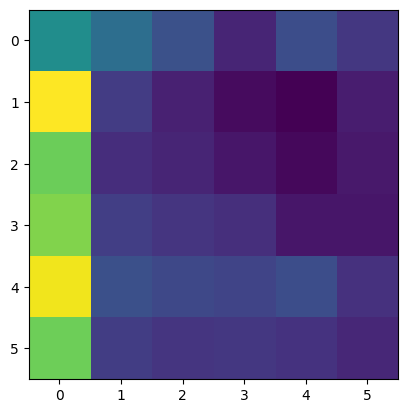

torch.Size([1, 8, 6, 6])

In [1247]:
# compute the attention matrix (broadcasting num_key_value_heads in k to n_heads in q)
# att_mat = torch.einsum("bhqd,bhkd->bhqk", q, k) / np.sqrt(head_dim)
att_mat = q_rot @ k_rot.transpose(-2, -1) / np.sqrt(head_dim)
plt.imshow(att_mat[0, 0].detach().numpy()); plt.show()
att_mat.shape

torch.Size([1, 1, 6, 6])


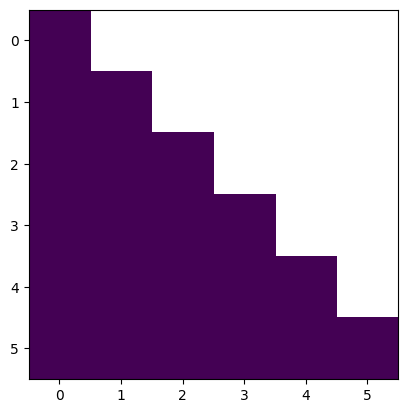

In [1248]:
# mask the attention matrix
att_mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)
att_mask = att_mask.unsqueeze(0).unsqueeze(0)
att_mask[att_mask==False] = float('-inf')
print(att_mask.shape)
plt.imshow(att_mask[0, 0].detach().numpy()); plt.show()

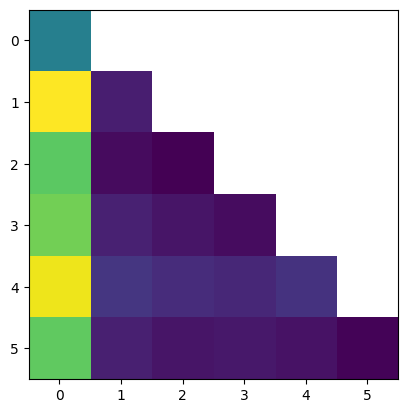

In [1249]:
# att_mat_masked = att_mat.masked_fill(att_mask == 0, float('-inf'))
att_mat_masked = att_mat + att_mask
plt.imshow(att_mat_masked[0, 0].detach().numpy()); plt.show()

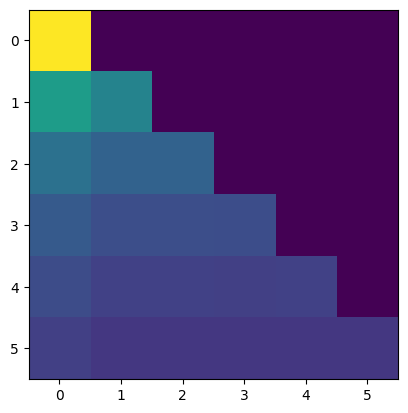

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]],
       grad_fn=<SumBackward1>)
torch.Size([1, 8, 6, 6])


In [1250]:
# compute attention scores
att_scores = F.softmax(att_mat_masked, dim=-1)
plt.imshow(att_scores[0, 0].detach().numpy()); plt.show()
print(att_scores.sum(-1))
print(att_scores.shape)

In [1251]:
# compute attention output
print(att_scores.shape, v.shape)
att_output = att_scores @ v
print(att_output.shape)

torch.Size([1, 8, 6, 6]) torch.Size([1, 1, 6, 256])
torch.Size([1, 8, 6, 256])


In [1252]:
# reorder axes from bsz, n_heads, seq_len, head_dim to bsz, seq_len, n_heads, head_dim
att_output = att_output.permute(0, 2, 1, 3)
att_output.shape

torch.Size([1, 6, 8, 256])

In [1253]:
# reshape to bsz, seq_len, dim
att_output = att_output.reshape(att_output.shape[0], att_output.shape[1], dim)
att_output.shape

torch.Size([1, 6, 2048])

In [1254]:
# apply output projection layer
att_output = o_proj(att_output)
att_output.shape

torch.Size([1, 6, 2048])

In [1258]:
# let's compare our attention outputs with original ones
att_out_gt, _, _ = model.model.layers[0].self_attn(embedding, attention_mask=att_mask, position_ids=position_ids)
torch.allclose(att_output, att_out_gt, atol=1e-7)

True

## MLP (GeGLU)


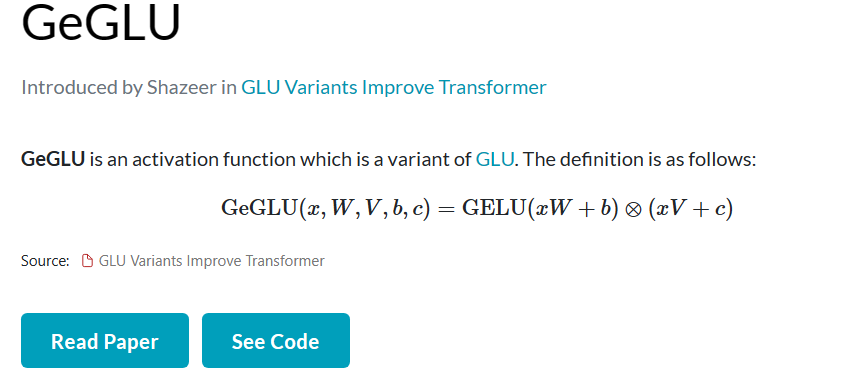

In [27]:
act = nn.GELU(approximate="tanh")

W_proj = nn.Linear(dim, fc_intermediate_size, bias=False)
V_proj = nn.Linear(dim, fc_intermediate_size, bias=False)
mlp_out_proj = nn.Linear(fc_intermediate_size, dim, bias=False)

W_proj.weight.data = weights["model.layers.0.mlp.gate_proj.weight"]
V_proj.weight.data = weights["model.layers.0.mlp.up_proj.weight"]
mlp_out_proj.weight.data = weights["model.layers.0.mlp.down_proj.weight"]

In [28]:
geglu_out = act(W_proj(embedding)) * V_proj(embedding)
geglu_out.shape

torch.Size([1, 6, 16384])

In [29]:
mlp_out = mlp_out_proj(geglu_out)
mlp_out

tensor([[[ 0.0921, -0.0508, -0.0405,  ..., -0.0137, -0.0294,  0.0081],
         [-0.0634, -0.0043,  0.0101,  ...,  0.0126, -0.0207,  0.0295],
         [-0.0637,  0.0097, -0.0154,  ...,  0.0114, -0.0262,  0.0156],
         [-0.0583,  0.0084,  0.0010,  ...,  0.0221, -0.0144,  0.0035],
         [-0.1189,  0.0287, -0.0022,  ...,  0.0220, -0.0344,  0.0222],
         [-0.0454, -0.0018, -0.0148,  ...,  0.0046, -0.0078,  0.0096]]],
       grad_fn=<UnsafeViewBackward0>)

In [30]:
torch.allclose(mlp_out, model.model.layers[0].mlp(embedding))

True

## Combine everything together -- dirty way
We will not create a model class, but create and load torch layers when we need them

In [188]:
sentence = """You are my """
# tokenize
tokens = tokenizer(sentence, return_tensors='pt')
# embedding layer
embedding_layer = nn.Embedding(vocab_size, dim)
embedding_layer.weight.data = weights['model.embed_tokens.weight']
x = embedding_layer(tokens.input_ids)
normalizer = torch.tensor(dim**0.5, dtype=x.dtype)
x = x * normalizer
bsz, seq_len = x.shape[0], x.shape[1]
# mask the attention matrix
att_mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)
att_mask = att_mask.unsqueeze(0).unsqueeze(0)
att_mask[att_mask==False] = float('-inf')
position_ids = torch.arange(1, seq_len+1).unsqueeze(0)
cos_vec = torch.Tensor([[torch.cos(angle*m), torch.cos(angle*m)] for m in range(1,seq_len+1) for angle in angles[:head_dim//2]]).reshape(seq_len, -1)
sin_vec = torch.Tensor([[torch.sin(angle*m), torch.sin(angle*m)] for m in range(1,seq_len+1) for angle in angles[:head_dim//2]]).reshape(seq_len, -1)
for i in tqdm(range(0, n_layers)):
    orig_x = model.model.layers[i](x, att_mask, position_ids)[0]
    rmsn_pre = RMSNorm(dim, eps=rms_norm_eps)
    rmsn_pre.gains.data = weights[f"model.layers.{i}.input_layernorm.weight"]
    q_proj = nn.Linear(dim, head_dim * n_heads, bias=False) # dim x dim
    k_proj = nn.Linear(dim, head_dim * num_key_value_heads, bias=False)
    v_proj = nn.Linear(dim, head_dim * num_key_value_heads, bias=False)
    o_proj = nn.Linear(dim, head_dim * n_heads, bias=False)
    q_proj.weight.data = weights[f"model.layers.{i}.self_attn.q_proj.weight"]
    k_proj.weight.data = weights[f"model.layers.{i}.self_attn.k_proj.weight"]
    v_proj.weight.data = weights[f"model.layers.{i}.self_attn.v_proj.weight"]
    o_proj.weight.data = weights[f"model.layers.{i}.self_attn.o_proj.weight"]
    # apply rmsn
    x_norm = rmsn_pre(x)
    # apply q,k,v projections
    q = q_proj(x_norm)
    k = k_proj(x_norm)
    v = v_proj(x_norm)
    # reshape to bsz, seq, n_heads, head_dim and reorder to bsz, n_heads, seq, head_dim
    q = q.view(bsz, seq_len, n_heads, head_dim).transpose(1, 2)
    k = k.view(bsz, seq_len, num_key_value_heads, head_dim).transpose(1, 2)
    v = v.view(bsz, seq_len, num_key_value_heads, head_dim).transpose(1, 2)
    # rotate q and k with ROPE
    q_rot = rotate_with_ROPE(sin_vec, cos_vec, q)
    k_rot = rotate_with_ROPE(sin_vec, cos_vec, k)
    # compute the attention matrix (broadcasting num_key_value_heads in k to n_heads in q)
    att_mat = q_rot @ k_rot.transpose(-2, -1) / np.sqrt(head_dim)
    # apply causal attention mask
    att_mat_masked = att_mat + att_mask
    # compute attention scores
    att_scores = F.softmax(att_mat_masked, dim=-1)
    # compute attention output
    att_output = att_scores @ v
    # reorder axes from bsz, n_heads, seq_len, head_dim to bsz, seq_len, n_heads, head_dim
    att_output = att_output.permute(0, 2, 1, 3)
    # reshape to bsz, seq_len, dim
    att_output = att_output.reshape(att_output.shape[0], att_output.shape[1], dim)
    # apply output projection layer
    att_output = o_proj(att_output)
    
    # apply residual connection
    x = x + att_output

    # MLP part
    rmsn_post = RMSNorm(dim, eps=rms_norm_eps)
    rmsn_post.gains.data = weights[f"model.layers.{i}.post_attention_layernorm.weight"]
    act = nn.GELU(approximate="tanh")
    W_proj = nn.Linear(dim, fc_intermediate_size, bias=False)
    V_proj = nn.Linear(dim, fc_intermediate_size, bias=False)
    mlp_out_proj = nn.Linear(fc_intermediate_size, dim, bias=False)
    W_proj.weight.data = weights[f"model.layers.{i}.mlp.gate_proj.weight"]
    V_proj.weight.data = weights[f"model.layers.{i}.mlp.up_proj.weight"]
    mlp_out_proj.weight.data = weights[f"model.layers.{i}.mlp.down_proj.weight"]

    # apply RMSNorm
    x_norm = rmsn_post(x)
    # apply GeGLU MLP
    mlp_out = mlp_out_proj(
        act(W_proj(x_norm)) * V_proj(x_norm)
    )
    # apply residual connection
    x = x + mlp_out

    # print if close to original
    print("all close", i, torch.allclose(x,orig_x,atol=1e-4))

# output layer
out_rmsn = RMSNorm(dim, eps=rms_norm_eps)
out_rmsn.gains.data = weights["model.norm.weight"]
out_lin_projection = nn.Linear(dim, vocab_size, bias=False)
out_lin_projection.weight.data = weights["lm_head.weight"]

x = out_rmsn(x)
x = out_lin_projection(x)

  6%|▌         | 1/18 [00:01<00:28,  1.68s/it]

all close 0 True


 11%|█         | 2/18 [00:03<00:25,  1.58s/it]

all close 1 True


 17%|█▋        | 3/18 [00:04<00:23,  1.58s/it]

all close 2 True


 22%|██▏       | 4/18 [00:06<00:21,  1.53s/it]

all close 3 True


 28%|██▊       | 5/18 [00:07<00:19,  1.49s/it]

all close 4 True


 33%|███▎      | 6/18 [00:09<00:17,  1.46s/it]

all close 5 True


 39%|███▉      | 7/18 [00:10<00:15,  1.45s/it]

all close 6 True


 44%|████▍     | 8/18 [00:11<00:14,  1.44s/it]

all close 7 True


 50%|█████     | 9/18 [00:13<00:13,  1.45s/it]

all close 8 True


 56%|█████▌    | 10/18 [00:14<00:11,  1.48s/it]

all close 9 True


 61%|██████    | 11/18 [00:16<00:10,  1.46s/it]

all close 10 True


 67%|██████▋   | 12/18 [00:17<00:08,  1.47s/it]

all close 11 True


 72%|███████▏  | 13/18 [00:19<00:07,  1.44s/it]

all close 12 True


 78%|███████▊  | 14/18 [00:20<00:05,  1.44s/it]

all close 13 True


 83%|████████▎ | 15/18 [00:22<00:04,  1.46s/it]

all close 14 True


 89%|████████▉ | 16/18 [00:23<00:02,  1.48s/it]

all close 15 True


 94%|█████████▍| 17/18 [00:25<00:01,  1.49s/it]

all close 16 True


100%|██████████| 18/18 [00:26<00:00,  1.48s/it]

all close 17 True


In [189]:
# Let's compute the output of original model and compare with our output
ret = model(
    tokens.input_ids,
    attention_mask=att_mask,
    position_ids=position_ids,
    output_hidden_states=True
)
torch.allclose(
    x,
    ret['logits'],
    atol=1e-5
)

True

In [195]:
# convert to text
tokenizer.decode(F.softmax(x[0,-2], dim=-1).topk(10).indices)

' sunshine favorite best hero only sun world everything first inspiration'

# Combine everything -- clean way

In [2]:
def rotate_with_ROPE(sin, cos, x, head_dim):
    index = torch.arange(0,head_dim).reshape(2,-1).transpose(0,1).reshape(-1)
    revert_index = torch.arange(0,head_dim).reshape(-1,2).T.flatten()

    # make order of features to x1,x128,...,x127,x254
    # numbers are current indices 1-based
    ee = x[:,:,:,index]

    # reorder -x2,x1,...,-xd,xd-1, numers are current indices 1-based
    new_order = [i + 1 if i % 2 == 0 else i - 1 for i in range(ee.shape[-1])]
    re = ee[:, :, :, new_order]
    re[:, :, :, 0::2] = -re[:, :, :, 0::2]

    # compute the full rotated embedding
    full_rotated_mat = re * sin + ee * cos

    # revert the order of features
    full_rotated_mat = full_rotated_mat[:,:,:,revert_index]

    return full_rotated_mat


class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.gains = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        rms = torch.sqrt(
            torch.mean(x**2, -1, keepdim=True) + self.eps
        )
        x = x / rms * (1 + self.gains)
        return x

In [21]:
class GemmaAttention(nn.Module):
    def __init__(self, dim, n_heads, num_key_value_heads, rms_norm_eps):
        super(GemmaAttention, self).__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.num_key_value_heads = num_key_value_heads

        self.q_proj = nn.Linear(dim, dim, bias=False) # dim x dim
        self.k_proj = nn.Linear(dim, self.head_dim * num_key_value_heads, bias=False)
        self.v_proj = nn.Linear(dim, self.head_dim * num_key_value_heads, bias=False)
        self.o_proj = nn.Linear(dim, dim, bias=False)
        self.rmsn_pre = RMSNorm(dim, eps=rms_norm_eps)

    def forward(self, x, att_mask, position_ids, sin_vec, cos_vec):
        bsz, seq_len = x.shape[0], x.shape[1]
        # apply rmsn
        x_norm = self.rmsn_pre(x)
        # apply q,k,v projections
        q = self.q_proj(x_norm)
        k = self.k_proj(x_norm)
        v = self.v_proj(x_norm)
        # reshape to bsz, seq, n_heads, head_dim and reorder to bsz, n_heads, seq, head_dim
        q = q.view(bsz, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(bsz, seq_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        v = v.view(bsz, seq_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        # rotate q and k with ROPE
        q_rot = rotate_with_ROPE(sin_vec, cos_vec, q, self.head_dim)
        k_rot = rotate_with_ROPE(sin_vec, cos_vec, k, self.head_dim)
        # compute the attention matrix (broadcasting num_key_value_heads in k to n_heads in q)
        att_mat = q_rot @ k_rot.transpose(-2, -1) / np.sqrt(self.head_dim)
        # apply causal attention mask
        att_mat_masked = att_mat + att_mask
        # compute attention scores
        att_scores = F.softmax(att_mat_masked, dim=-1)
        # compute attention output
        att_output = att_scores @ v
        # reorder axes from bsz, n_heads, seq_len, head_dim to bsz, seq_len, n_heads, head_dim
        att_output = att_output.permute(0, 2, 1, 3)
        # reshape to bsz, seq_len, dim
        att_output = att_output.reshape(att_output.shape[0], att_output.shape[1], self.dim)
        # apply output projection layer
        att_output = self.o_proj(att_output)
        
        # apply residual connection
        x = x + att_output

        return x

class GemmaMLP(nn.Module):
    def __init__(self, dim, fc_intermediate_size, rms_norm_eps):
        super(GemmaMLP, self).__init__()
        self.rmsn_post = RMSNorm(dim, eps=rms_norm_eps)
        self.act = nn.GELU(approximate="tanh")
        self.W_proj = nn.Linear(dim, fc_intermediate_size, bias=False)
        self.V_proj = nn.Linear(dim, fc_intermediate_size, bias=False)
        self.mlp_out_proj = nn.Linear(fc_intermediate_size, dim, bias=False)

    def forward(self, x):
        # apply RMSNorm
        x_norm = self.rmsn_post(x)
        # apply GeGLU MLP
        mlp_out = self.mlp_out_proj(
            self.act(self.W_proj(x_norm)) * self.V_proj(x_norm)
        )
        # apply residual connection
        x = x + mlp_out
        return x

class GemmaLayer(nn.Module):
    def __init__(self, dim, n_heads, num_key_value_heads, rms_norm_eps, fc_intermediate_size):
        super(GemmaLayer, self).__init__()
        self.attention = GemmaAttention(dim, n_heads, num_key_value_heads, rms_norm_eps)
        self.mlp = GemmaMLP(dim, fc_intermediate_size, rms_norm_eps)

    def forward(self, x, att_mask, position_ids, sin_vec, cos_vec):
        x = self.attention(x, att_mask, position_ids, sin_vec, cos_vec)
        x = self.mlp(x)
        return x


class Gemma(nn.Module):
    def __init__(self, dim, n_layers, n_heads, num_key_value_heads, fc_intermediate_size, vocab_size, rms_norm_eps, max_position_embeddings):
        super(Gemma, self).__init__()
        self.dim = dim
        self.head_dim = dim // n_heads
        self.n_layers = n_layers
        self.embedding_layer = nn.Embedding(vocab_size, dim)
        self.layers = nn.ModuleList([
            GemmaLayer(dim, n_heads, num_key_value_heads, rms_norm_eps, fc_intermediate_size)
            for _ in range(n_layers)
        ])
        self.out_rmsn = RMSNorm(dim, eps=rms_norm_eps)
        self.out_lin_projection = nn.Linear(dim, vocab_size, bias=False)
        self.angles = torch.Tensor([10000**(-2*i/self.head_dim) for i in range(self.head_dim//2)])

    def forward(self, x):
        # embedding layer
        x = self.embedding_layer(x)

        # normalize
        normalizer = torch.tensor(self.dim**0.5, dtype=x.dtype, device=x.device)
        x = x * normalizer

        # create attention mask
        bsz, seq_len = x.shape[0], x.shape[1]
        att_mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)
        att_mask = att_mask.unsqueeze(0).unsqueeze(0)
        att_mask[att_mask==False] = float('-inf')
        position_ids = torch.arange(1, seq_len+1).unsqueeze(0)

        # create sin and cos vectors
        cos_vec = torch.Tensor([
            [torch.cos(angle*m), torch.cos(angle*m)] for m in range(1,seq_len+1) for angle in self.angles
        ], device=x.device).reshape(seq_len, -1)
        sin_vec = torch.Tensor([
            [torch.sin(angle*m), torch.sin(angle*m)] for m in range(1,seq_len+1) for angle in self.angles
        ], device=x.device).reshape(seq_len, -1)
        
        # apply layers
        for i in range(self.n_layers):
            x = self.layers[i].attention(
                x, att_mask, position_ids, sin_vec, cos_vec)
            x = self.layers[i].mlp(x)

        # output layer
        x = self.out_rmsn(x)
        x = self.out_lin_projection(x)

        return x

    def load_hf_weights(self, weights):
        # embedding layer
        self.embedding_layer.weight.data = weights['model.embed_tokens.weight']

        # decoder layers
        for i in range(0, self.n_layers):
            # self attention
            self.layers[i].attention.q_proj.weight.data = weights[f"model.layers.{i}.self_attn.q_proj.weight"]
            self.layers[i].attention.k_proj.weight.data = weights[f"model.layers.{i}.self_attn.k_proj.weight"]
            self.layers[i].attention.v_proj.weight.data = weights[f"model.layers.{i}.self_attn.v_proj.weight"]
            self.layers[i].attention.o_proj.weight.data = weights[f"model.layers.{i}.self_attn.o_proj.weight"]
            self.layers[i].attention.rmsn_pre.gains.data = weights[f"model.layers.{i}.input_layernorm.weight"]
            # MLP
            self.layers[i].mlp.W_proj.weight.data = weights[f"model.layers.{i}.mlp.gate_proj.weight"]
            self.layers[i].mlp.V_proj.weight.data = weights[f"model.layers.{i}.mlp.up_proj.weight"]
            self.layers[i].mlp.mlp_out_proj.weight.data = weights[f"model.layers.{i}.mlp.down_proj.weight"]
            self.layers[i].mlp.rmsn_post.gains.data = weights[f"model.layers.{i}.post_attention_layernorm.weight"]

        # output layer
        self.out_rmsn.gains.data = weights["model.norm.weight"]
        self.out_lin_projection.weight.data = weights["lm_head.weight"]

In [51]:
torch.no_grad()

custom_model = Gemma(
    dim, n_layers, n_heads, num_key_value_heads, fc_intermediate_size, vocab_size, rms_norm_eps, max_position_embeddings
)
custom_model.load_hf_weights(weights)
custom_model

Gemma(
  (embedding_layer): Embedding(256000, 2048)
  (layers): ModuleList(
    (0-17): 18 x GemmaLayer(
      (attention): GemmaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rmsn_pre): RMSNorm()
      )
      (mlp): GemmaMLP(
        (rmsn_post): RMSNorm()
        (act): GELU(approximate='tanh')
        (W_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (V_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (mlp_out_proj): Linear(in_features=16384, out_features=2048, bias=False)
      )
    )
  )
  (out_rmsn): RMSNorm()
  (out_lin_projection): Linear(in_features=2048, out_features=256000, bias=False)
)

In [14]:
input_ids = tokenizer("You are my ", return_tensors="pt").input_ids

out_logits = custom_model(input_ids)

In [ ]:
custom_model.to('cuda').layers[0].attention.rmsn_pre.gains.device

In [16]:
out_logits_orig = model(input_ids)['logits']

In [17]:
torch.allclose(out_logits, out_logits_orig, atol=1e-5)

True

In [240]:
# convert to text
tokenizer.decode(F.softmax(out_logits[0,-2], dim=-1).topk(10).indices)

' sunshine favorite best hero only sun world everything first inspiration'

# Create a generate function

In [62]:
# let's now create a function to generate text with our model
def generate_text(model, tokenizer, prompt, max_length=10):
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        for _ in tqdm(range(max_length)):
            out_logits = model(input_ids)
            next_token = F.softmax(out_logits[0,-1], dim=-1).argmax()
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0).unsqueeze(0)], dim=-1)
            if next_token == tokenizer.eos_token_id:
                break
        return tokenizer.decode(input_ids[0])

In [63]:
sentence = "You are my "

generate_text(custom_model, tokenizer, sentence)

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


'<bos>You are my <strong>best friend</strong>, my <strong>soulmate'

In [69]:
tokenizer.decode(
    model.generate(tokenizer(sentence, return_tensors="pt").input_ids)[0]
)

'<bos>You are my <strong>best friend</strong>, my <strong>soulmate</strong>, my <strong>'

# Gemma weights from PaliGemma

In [4]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests

model_id = "google/paligemma-3b-mix-224"
pg_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


In [5]:
prompt = "detect bee?"
image_file = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg?download=true"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(prompt, raw_image, return_tensors="pt")
output = pg_model.generate(**inputs, max_new_tokens=20)

print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



<loc0476><loc0455><loc0579><loc0512> bee


In [6]:
pg_text_config = pg_model.config.text_config

In [22]:
torch.no_grad()

custom_model = Gemma(
    dim = pg_text_config.hidden_size,
    n_layers = pg_text_config.num_hidden_layers,
    n_heads = pg_text_config.num_attention_heads,
    num_key_value_heads = pg_text_config.num_key_value_heads,
    fc_intermediate_size = pg_text_config.intermediate_size,
    vocab_size = pg_text_config.vocab_size,
    rms_norm_eps = pg_text_config.rms_norm_eps,
    max_position_embeddings = pg_text_config.max_position_embeddings
)
# custom_model.load_hf_weights(weights)
custom_model

Gemma(
  (embedding_layer): Embedding(257216, 2048)
  (layers): ModuleList(
    (0-17): 18 x GemmaLayer(
      (attention): GemmaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rmsn_pre): RMSNorm()
      )
      (mlp): GemmaMLP(
        (rmsn_post): RMSNorm()
        (act): GELU(approximate='tanh')
        (W_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (V_proj): Linear(in_features=2048, out_features=16384, bias=False)
        (mlp_out_proj): Linear(in_features=16384, out_features=2048, bias=False)
      )
    )
  )
  (out_rmsn): RMSNorm()
  (out_lin_projection): Linear(in_features=2048, out_features=257216, bias=False)
)

In [23]:
custom_model.load_hf_weights(pg_model.language_model.state_dict())

In [24]:
# print number of parameters for custom_model and pg_model
print(sum(p.numel() for p in custom_model.parameters()))
print(sum(p.numel() for p in pg_model.language_model.parameters()))

3035441152
2508662784


In [39]:
# create a random input tensor
input_ids = torch.randint(0, pg_text_config.vocab_size, (1, 20))
input_ids


tensor([[  5706, 125942, 151223, 139977,  96629, 160977, 251909, 209214,   6190,
         102413, 247227,  84615,  12321, 102069, 250598, 165257, 213011, 223305,
         108701, 223214]])

In [40]:
cutom_out = custom_model(input_ids)
print(cutom_out.shape)
cutom_out

torch.Size([1, 20, 257216])


tensor([[[ -0.0916,   5.1240, -15.7540,  ...,  -0.8838,  -0.8866,  -0.8847],
         [  0.6308,   4.3901, -20.1562,  ...,  -0.8476,  -0.8535,  -0.8455],
         [ -0.1848,   5.5989, -21.0075,  ...,  -0.8385,  -0.8447,  -0.8407],
         ...,
         [ -0.1042,   0.3676, -10.0569,  ...,  -1.7666,  -1.7766,  -1.7793],
         [  0.3203,   0.7445, -15.5378,  ...,  -1.6099,  -1.6231,  -1.6265],
         [  1.3958,   5.7269, -15.0676,  ...,  -0.5363,  -0.5472,  -0.5411]]],
       grad_fn=<UnsafeViewBackward0>)

In [41]:
pg_out = pg_model.language_model(input_ids)
pg_out.logits

tensor([[[ -0.0916,   5.1240, -15.7540,  ...,  -0.8838,  -0.8866,  -0.8847],
         [  0.6308,   4.3901, -20.1562,  ...,  -0.8476,  -0.8535,  -0.8455],
         [ -0.1848,   5.5989, -21.0075,  ...,  -0.8385,  -0.8447,  -0.8406],
         ...,
         [ -0.1042,   0.3676, -10.0569,  ...,  -1.7666,  -1.7766,  -1.7793],
         [  0.3203,   0.7445, -15.5378,  ...,  -1.6099,  -1.6231,  -1.6265],
         [  1.3958,   5.7269, -15.0676,  ...,  -0.5363,  -0.5473,  -0.5411]]],
       grad_fn=<UnsafeViewBackward0>)

In [44]:
# compare the outputs
torch.allclose(cutom_out, pg_out.logits, atol=1e-4)

True